<a href="https://colab.research.google.com/github/LordSrapnel/0.0.0c/blob/main/CatFish_PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget -O images.zip https://www.dropbox.com/s/46j2uy5b41e8c6a/images.zip?dl=0
# !unzip images.zip;

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            # 3 - число каналов(только на первом слою), 64 - число фильтров
            # kernel_size - размер ядра, stride - шаг, padding - число строк и столбцов с 0
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # функция активации релу max(0,x)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # AdaptiveAvgPool2d - позволяет подогнать под заданный размер с помощью подвыборки
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            # Linear полносвязный слой, первый аргумент число входов, второй число нейронов
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # torch.flatten плоский слой, матрицу в вектор
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
cnnnet = CNNNet()

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
  x=range(1,epochs+1)
  y_train_loss=[]
  y_val_loss=[]

  for epoch in range(1, epochs+1):
      # счетчик ошибки
      training_loss = 0.0
      valid_loss = 0.0
      model.train()
      for batch in train_loader:
        # цикл мини выборки для тренировочного набора данных
        # Оптимизатор обнуление градиента
          optimizer.zero_grad()
          # выгрузка входов и выходов из батча
          inputs, targets = batch
          # загружаем данные в озу выбранного устройства
          inputs = inputs.to(device)
          targets = targets.to(device)
          # прогон через нейросеть
          output = model(inputs)
          # нахождение потери с помощью функции потери
          loss = loss_fn(output, targets)
          # обратное распростронение ошибки
          loss.backward()
          # шаг оптимизатора
          optimizer.step()
          # добавить ошибку на батче к общей ошибке на эпохе
          training_loss += loss.data.item() * inputs.size(0)
      # находим среднюю ошибку
      training_loss /= len(train_loader.dataset)
      
      model.eval()
      num_correct = 0 
      num_examples = 0
      for batch in val_loader:
          inputs, targets = batch
          inputs = inputs.to(device)
          output = model(inputs)
          targets = targets.to(device)
          loss = loss_fn(output,targets) 
          valid_loss += loss.data.item() * inputs.size(0)
          # Считаем долю правельных ответов (для задач классификации)
          correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                              targets)
          num_correct += torch.sum(correct).item()
          num_examples += correct.shape[0]
      valid_loss /= len(val_loader.dataset)

      # добавление потерь для графика
      y_train_loss.append(training_loss)
      y_val_loss.append(valid_loss)
      # вывод на экран
      print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, val_accuracy = {:.2f}'.format(epoch, training_loss,
      valid_loss, num_correct / num_examples))
  return x,y_train_loss,y_val_loss

In [ ]:
def check_image(path):
  # Проверка изображения
    try:
        im = Image.open(path)
        return True
    except:
        return False
# трансформер изображения (нормализация) mean и std из imageNet
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
# Подготовка загрузчиков
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
# батч сайз размер мини выборки, отвечает за то сколько фоток за раз грузим
# shuffle - перемешать фай
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

# выбор устройсва
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
cnnnet.to(device)
# оптимизатор Adam с скоростью обучения 0.001
optimizer = optim.Adam(cnnnet.parameters(), lr=0.001)

In [ ]:
x, y_train,y_val=train(cnnnet, #экземпляр сети
                       optimizer, #экземпляр оптимизатора
                       torch.nn.CrossEntropyLoss(), # функция потери
                       train_data_loader,val_data_loader, # данные (трейн и вайл)
                       epochs=10, device=device
                       )

Epoch: 1, Training Loss: 0.36, Validation Loss: 0.41, val_accuracy = 0.82
Epoch: 2, Training Loss: 0.32, Validation Loss: 0.31, val_accuracy = 0.85
Epoch: 3, Training Loss: 0.28, Validation Loss: 0.96, val_accuracy = 0.62
Epoch: 4, Training Loss: 0.28, Validation Loss: 0.56, val_accuracy = 0.78
Epoch: 5, Training Loss: 0.30, Validation Loss: 0.41, val_accuracy = 0.76
Epoch: 6, Training Loss: 0.27, Validation Loss: 0.52, val_accuracy = 0.71
Epoch: 7, Training Loss: 0.23, Validation Loss: 0.88, val_accuracy = 0.68
Epoch: 8, Training Loss: 0.20, Validation Loss: 1.25, val_accuracy = 0.64
Epoch: 9, Training Loss: 0.30, Validation Loss: 0.48, val_accuracy = 0.76
Epoch: 10, Training Loss: 0.23, Validation Loss: 0.94, val_accuracy = 0.64


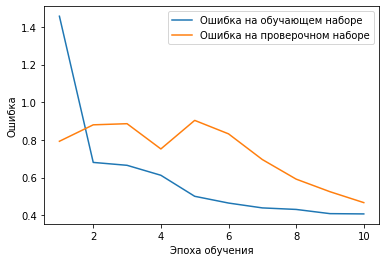

In [ ]:
plt.plot(x,y_train, 
         label='Ошибка на обучающем наборе')
plt.plot(x,y_val, 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()